In [1]:
import numpy as np
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from IPython.display import Audio,Image
from PIL import Image as PIL_Image
import multiprocessing
from joblib import Parallel,delayed

import os,sys
os.system("taskset -p 0xff %d" % os.getpid())
sys.path.append(os.path.expanduser('~')+'/audio_class/python')
sys.path.append('../../audio_class/python')
import utils
import ridgeDTW
import delay2loc

#%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
DATAROOT = './BBSPjun5_13/'

In [3]:
'''
for file in os.listdir(DATAROOT):
    print(file)
    fs,data = utils.readSegment(DATAROOT+file)
    break
'''
fs,data = utils.readSegment(DATAROOT+'day2-1370485107.wav')

In [4]:
print('fs = %s' % fs)
(nCh,nDat) = np.shape(data)
print('nCh = %s, nDat = %s' % (nCh,nDat))
Audio(data[0,:],rate=fs)

fs = 44100
nCh = 8, nDat = 2646000


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [5]:
nFft = 1024
def ridgePar(k,data,fs,btTime):
    S,F,T,tBlk,tInc = utils.spectrographic(data[k,:],fs,0.032,0.004,nFft)
    X = ridgeDTW.ridgeTracker(S,np.median(S.flatten()),btTime,tInc,isMaxPool=False)
    return T,F,X

btTime = 0.002
rvs = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(ridgePar)(k,data,fs,btTime) for k in range(nCh))

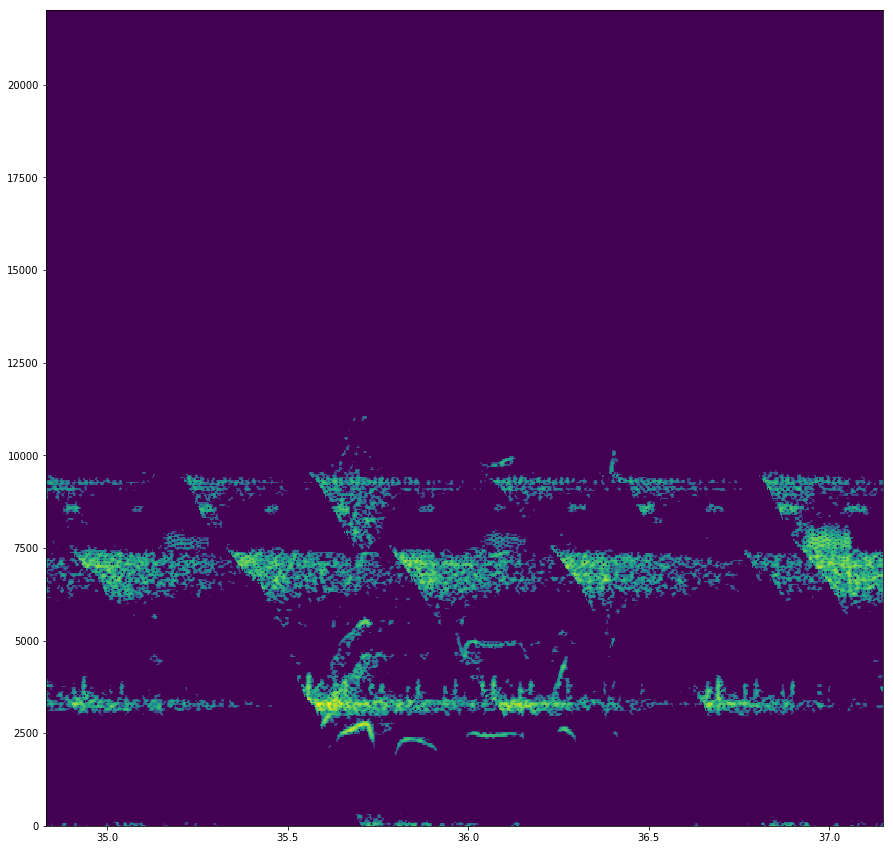

In [6]:
n1 = 12000
n2 = 12800
plt.figure(figsize=(15,15))
T,F,X = rvs[4]
plt.pcolormesh(T[n1:n2],F,np.sqrt(X[:,n1:n2]))

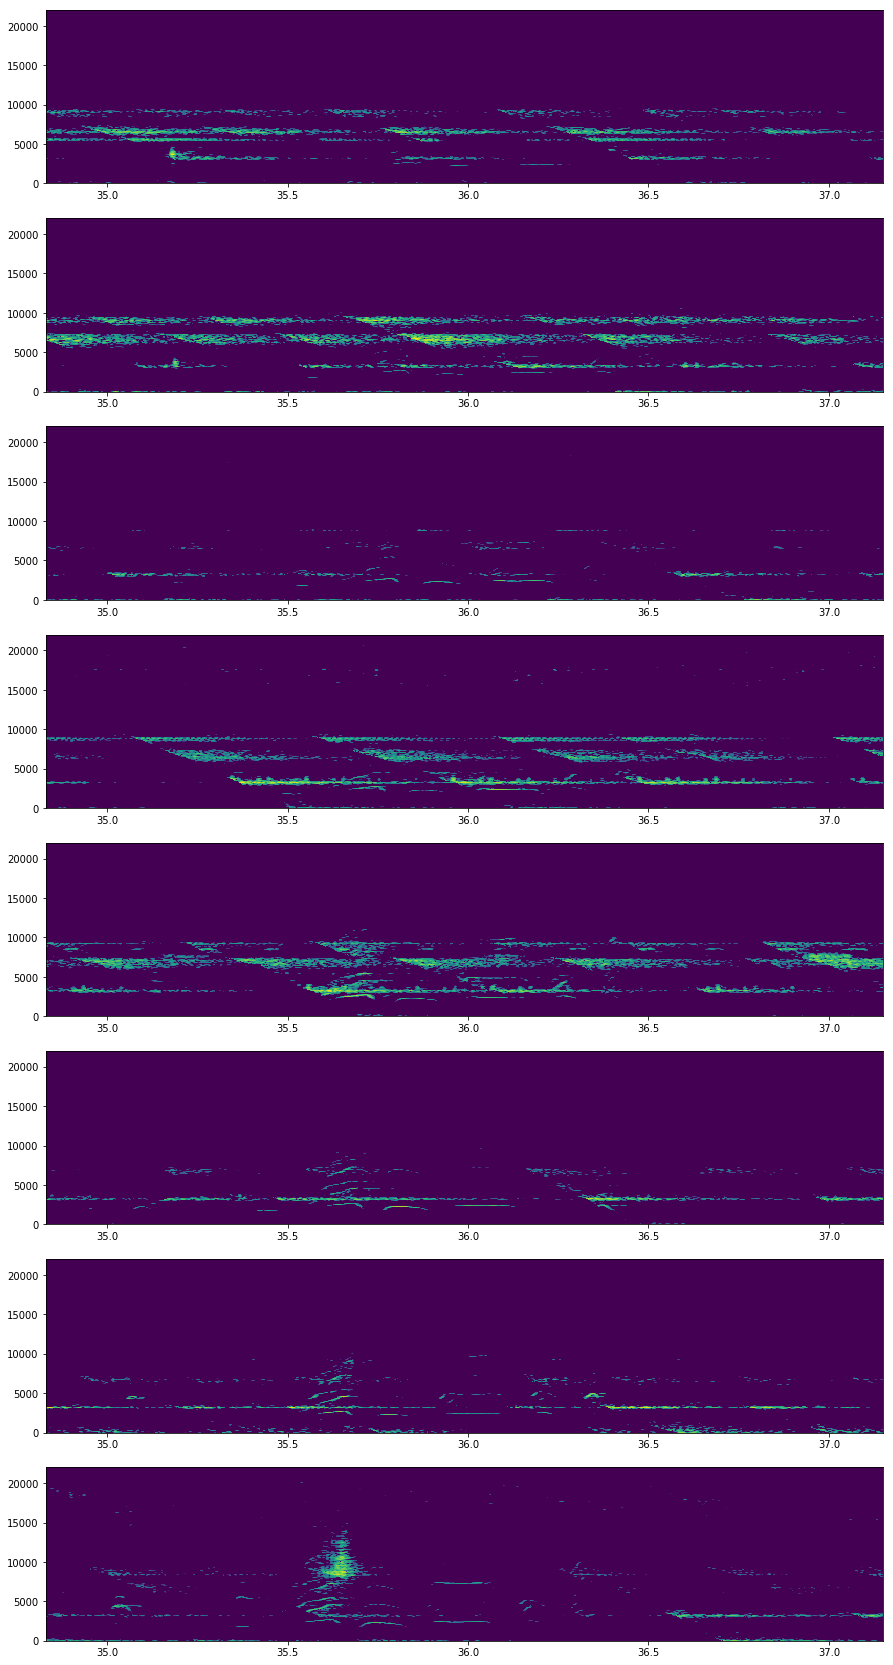

In [7]:
plt.figure(figsize=(15,30))
for k in range(nCh):
    plt.subplot(nCh,1,1+k)
    T,F,X = rvs[k]
    plt.pcolormesh(T[n1:n2],F,np.sqrt(X[:,n1:n2]))

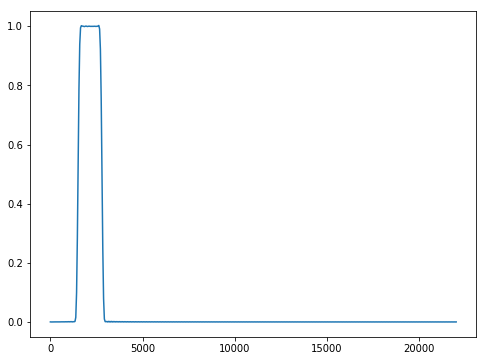

In [8]:
h = sp.signal.firwin(nFft//2,[1500,2800],nyq = fs/2,pass_zero=False)
w,H = sp.signal.freqz(h)

plt.figure(figsize=(8,6))
plt.plot(w/np.pi*(fs/2),abs(H))

H = np.expand_dims(np.abs(H),axis=0)

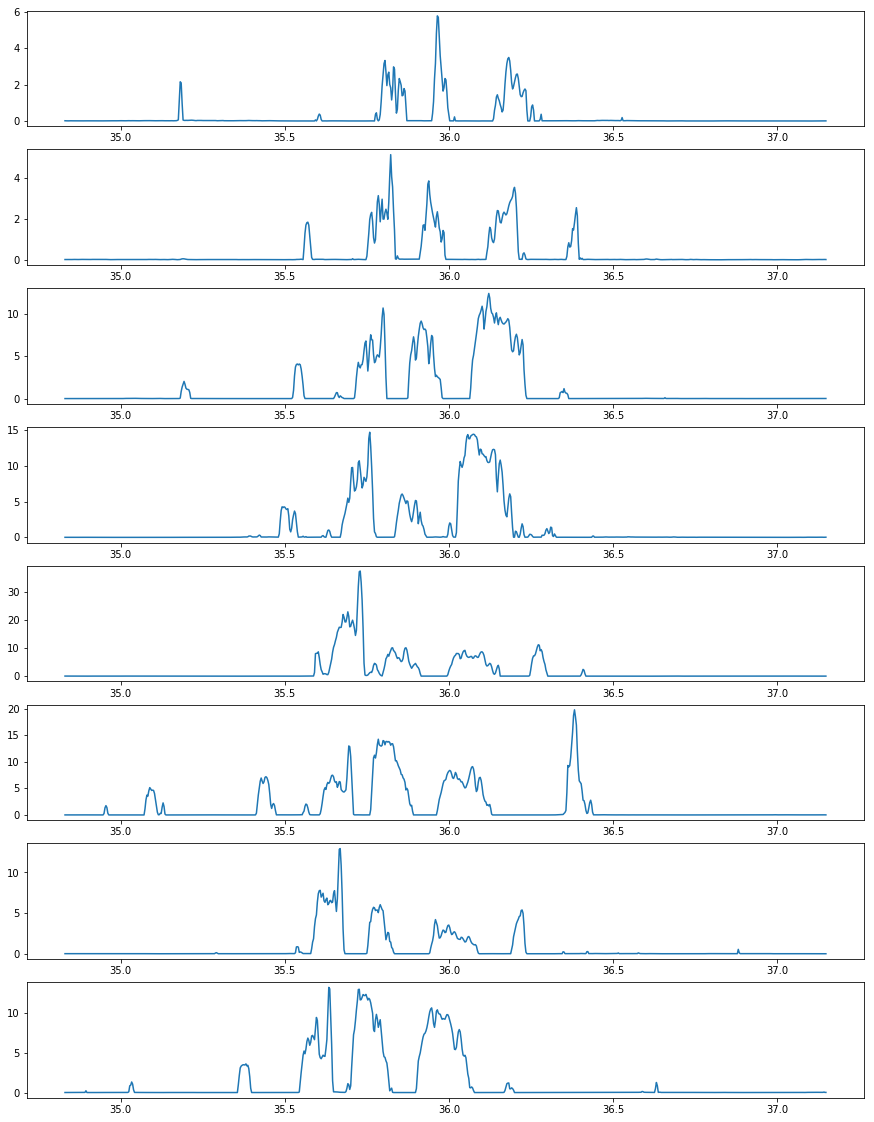

In [9]:
plt.figure(figsize=(15,20))
out = [None]*nCh
for k in range(nCh):
    plt.subplot(nCh,1,1+k)
    T,F,X = rvs[k]
    out[k] = np.squeeze(np.dot(H,X))
    plt.plot(T[n1:n2],out[k][n1:n2])

742


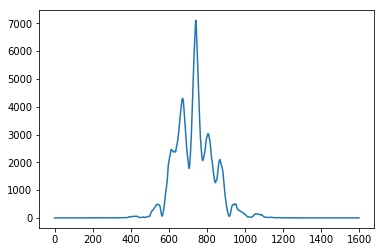

In [10]:
corr = sp.signal.correlate(out[7][n1:n2],out[2][n1:n2])
print(np.argmax(corr))
plt.figure()
plt.plot(corr)
#print(T[0:5])
#print(np.diff(T[0:5]))

In [11]:
meas_delayMat = np.zeros((nCh,nCh))
mid = n2-n1
tDelta = T[1]-T[0]
for k in range(nCh):
    for l in range(k+1,nCh):
        meas_delayMat[k,l] = meas_delayMat[l,k] = \
            tDelta*(np.argmax(sp.signal.correlate(out[k][n1:n2],out[l][n1:n2]))-mid)

In [12]:
print(meas_delayMat)

[[ 0.          0.02321995  0.0522449   0.09868481  0.12480726  0.15963719
   0.19156463  0.22639456]
 [ 0.02321995  0.          0.02321995  0.06385488  0.09287982  0.12480726
   0.15673469  0.18866213]
 [ 0.0522449   0.02321995  0.          0.03773243  0.06675737  0.1015873
   0.12770975  0.16253968]
 [ 0.09868481  0.06385488  0.03773243  0.          0.02612245  0.06095238
   0.08707483  0.12190476]
 [ 0.12480726  0.09287982  0.06675737  0.02612245  0.         -0.11029478
   0.05804989  0.09287982]
 [ 0.15963719  0.12480726  0.1015873   0.06095238 -0.11029478  0.
   0.02612245  0.05804989]
 [ 0.19156463  0.15673469  0.12770975  0.08707483  0.05804989  0.02612245
   0.          0.03192744]
 [ 0.22639456  0.18866213  0.16253968  0.12190476  0.09287982  0.05804989
   0.03192744  0.        ]]


In [13]:
# load mics' locations
micsloc = []
with open('micloc1.csv','r') as fid:
    for lines in fid:
        tokens = lines.split(',')
        micsloc.append([float(tokens[0]),float(tokens[1]),float(tokens[2])])
micsloc = np.array(micsloc)
print('micsloc = %s' % micsloc)

micsloc = [[-39.624   -3.048    3.048 ]
 [-30.48     0.       3.048 ]
 [-21.336    0.       0.9144]
 [-12.192   -3.048    0.9144]
 [ -3.048   -3.048    3.048 ]
 [  6.096    0.       3.048 ]
 [ 15.24    -3.048    0.9144]
 [ 24.384    0.       0.9144]]


In [14]:
loc,err = delay2loc.delay2loc_grad(micsloc,meas_delayMat)

nIter = 1, |grad| = 4.34961195589e-05, mu = 1.0
nIter = 2, |grad| = 4.22452519165e-05, mu = 1.0
nIter = 3, |grad| = 4.1437269722e-05, mu = 1.0
nIter = 4, |grad| = 4.10737226818e-05, mu = 1.0
nIter = 5, |grad| = 4.11361031812e-05, mu = 1.0
nIter = 6, |grad| = 4.15881763649e-05, mu = 1.0
nIter = 7, |grad| = 4.23807151018e-05, mu = 1.0
nIter = 8, |grad| = 4.34572883142e-05, mu = 1.0
nIter = 9, |grad| = 4.47596868196e-05, mu = 1.0
nIter = 10, |grad| = 4.62320724133e-05, mu = 1.0
nIter = 11, |grad| = 4.78235815033e-05, mu = 1.0
nIter = 12, |grad| = 4.94895773561e-05, mu = 1.0
nIter = 13, |grad| = 5.119194013e-05, mu = 1.0
nIter = 14, |grad| = 5.2898784652e-05, mu = 1.0
nIter = 15, |grad| = 5.45839075706e-05, mu = 1.0
nIter = 16, |grad| = 5.6226161009e-05, mu = 1.0
nIter = 17, |grad| = 5.78088625196e-05, mu = 1.0
nIter = 18, |grad| = 5.93192892934e-05, mu = 1.0
nIter = 19, |grad| = 6.07482654821e-05, mu = 1.0
nIter = 20, |grad| = 6.2089829566e-05, mu = 1.0
nIter = 21, |grad| = 6.33409587096e

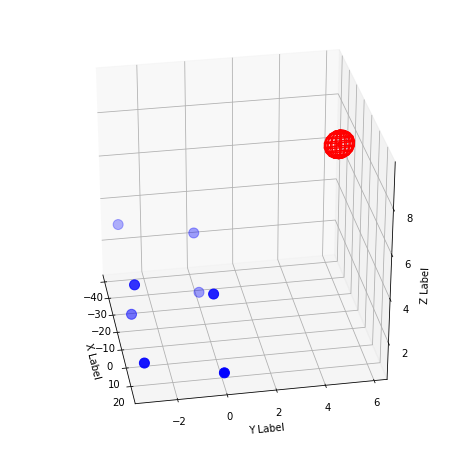

In [96]:
# Refs: TRTimage.py from mpop
def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring ( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( w, h, 4 ) # quick reshape
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf

def draw_ball(axes,cen,rad):
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = rad*np.cos(u)*np.sin(v)
    y = rad*np.sin(u)*np.sin(v)
    z = rad*np.cos(v)
    axes.plot_wireframe(cen[0]+x,cen[1]+y,cen[2]+z,color="r")

fig = plt.figure(figsize=(8,8))
axes = fig.gca(projection='3d')
axes.scatter(micsloc[:,0],micsloc[:,1],micsloc[:,2],s=100,c='b')
axes.scatter(loc[0],loc[1],loc[2],c='r')
draw_ball(axes,loc,err*50)
axes.set_xlabel('X Label')
axes.set_ylabel('Y Label')
axes.set_zlabel('Z Label')

images = []
for angle in range(0,360,10):
    axes.view_init(30, angle)
    imData = fig2data(fig)
    w,h,d = imData.shape
    im = PIL_Image.frombytes('RGBA',(w,h),imData)
    images.append(im)

(576, 576)
True
36
True
<PIL.Image.Image image mode=RGBA size=576x576 at 0x7FD15C9A2F98>


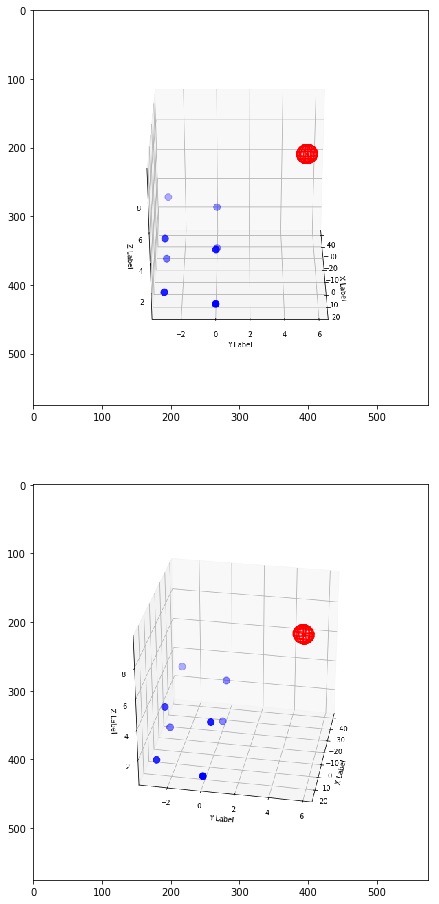

In [97]:
# sanity checks
size = fig.get_size_inches()*fig.dpi # size in pixels
size = tuple(size.astype(int))
print(size)
#print('(%s, %s)' % (w,h))
print(size == (w,h))

# verify that the number of frames in the gif equals the number of image files and durations
print(len(images))
print(PIL_Image.open(gif_pathname).n_frames == len(images))

print(images[0])
plt.figure(figsize=(8,16))
plt.subplot(211)
plt.imshow(images[0])
plt.subplot(212)
plt.imshow(images[1])

In [98]:
# Animate
gif_pathname = 'images/micsloc_srcloc.gif'
gif = images[0]
gif.info['duration'] = tuple([100]*len(images)) # ms per frame
gif.info['loop'] = 0 # how many times to loop (0=infinite)
gif.save(fp=gif_pathname, format='gif', save_all=True, append_images=images[1:])
# might need to refresh the page to reload the image,
# according to https://github.com/jupyter/notebook/issues/1369
Image(url=gif_pathname)

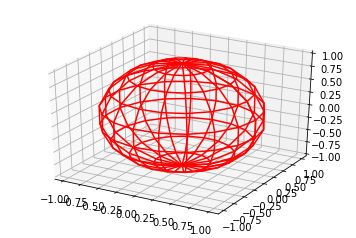

In [92]:
fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.set_aspect("equal")

u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, color="r")